<a href="https://colab.research.google.com/github/shivsharanrupesh/GenAI_Agents_Journey/blob/main/Langgraph/langgraph_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[reff: Langgraph_Chains.ipynb]

In the previous router, we invoked the model and, if it chose to call a tool, we returned a ToolMessage to the user.

But, what if we simply pass that ToolMessage back to the model?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind ReAct, a general agent architecture.

act - let the model call specific tools
observe - pass the tool output back to the model
reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

In [ ]:
pip install langchain_groq langgraph langgraph-cli[inmem] langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.6/452.6 kB 29.0 MB/s eta 0:00:00


In [ ]:
from openai import OpenAI
from google.colab import userdata
api_key = userdata.get('GROQ_API_KEY')

api_key = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key=api_key)

In [ ]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """
    Multiplies two integers.

    Args:
    -----
        a (int): First integer.
        b (int): Second integer.

    Returns:
    --------
        int: The product of a and b.
    """
    return a * b

def add(a: int, b: int) -> int:
    """
    Adds two integers.

    Args:
    -----
        a (int): First integer.
        b (int): Second integer.

    Returns:
    --------
        int: The sum of a and b.
    """
    return a + b

def divide(a: int, b: int) -> float:
    """
    Divides two integers.

    Args:
    -----
        a (int): First integer.
        b (int): Second integer.

    Returns:
    --------
        float: The quotient of a divided by b.

    Raises:
    -------
        ValueError: If `b` is zero to prevent division by zero.
    """
    if b == 0:
        raise ValueError("Division by zero is not allowed.")
    return a / b

# List of functions to be used as tools for the language model
tools = [add, multiply, divide]

# Initialize the LLM with GPT-4o
api_key = "your_api_key_here"  # Ensure this is securely managed
llm = ChatOpenAI(model="gpt-4o", api_key=api_key)

# Bind the tools to the LLM
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)


In [ ]:
from langgraph.graph import MessagesState

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    """
    Represents the state structure for storing messages in the conversation.

    Attributes:
    -----------
    messages : list[AnyMessage]
        A list of messages exchanged within the conversation. The `add_messages`
        function is applied to handle modifications dynamically.
    """
    messages: Annotated[list[AnyMessage], add_messages]


In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

# System message for context setting
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState) -> MessagesState:
    """
    Processes the conversation state by invoking the LLM with system instructions
    and user-provided messages.

    Parameters:
    -----------
    state : MessagesState
        A dictionary containing a list of messages (`messages`) that need to be processed.

    Returns:
    --------
    MessagesState:
        A dictionary with the updated `messages` list, where the LLM's response
        is appended to the conversation.
    """
    try:
        # Invoke LLM with system message + user messages
        response = llm_with_tools.invoke([sys_msg] + state["messages"])

        # Return updated messages state
        return {"messages": [response]}

    except Exception as e:
        print(f"Error in assistant function: {e}")
        return {"messages": [SystemMessage(content="An error occurred while processing your request. Please try again.")]}



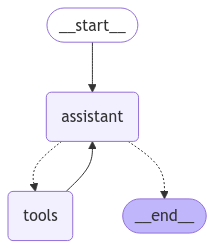

In [ ]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Initialize the StateGraph with MessagesState
builder = StateGraph(MessagesState)

## Define Nodes
builder.add_node("assistant", assistant)  # Chatbot assistant node
builder.add_node("tools", ToolNode(tools))  # Tool execution node

## Define Edges
builder.add_edge(START, "assistant")  # Start at assistant node

builder.add_conditional_edges(
    "assistant",
    tools_condition,  # Route based on assistant's tool call decision
)

builder.add_edge("tools", "assistant")  # Loop back to assistant after tool execution
builder.add_edge("assistant", END)  # End execution if no tool call

# Compile the graph
react_graph = builder.compile()

# Display the graph as a visual representation
display(Image(react_graph.get_graph().draw_mermaid_png()))


In [ ]:
messages = [HumanMessage(content="Add 10 and 14. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 10 and 14. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_3Wq5O9T3Sb7QEgtK53lBGIFI)
 Call ID: call_3Wq5O9T3Sb7QEgtK53lBGIFI
  Args:
    a: 10
    b: 14
================================= Tool Message =================================
Name: add

24
================================== Ai Message ==================================
Tool Calls:
  multiply (call_4RTXu63Df4MUqprBmpAKBBPz)
 Call ID: call_4RTXu63Df4MUqprBmpAKBBPz
  Args:
    a: 24
    b: 2
================================= Tool Message =================================
Name: multiply

48
================================== Ai Message ==================================
Tool Calls:
  divide (call_NMWYVc6TOBcP9ft99UcUKcWg)
 Call ID: call_NMWYVc6TOBcP9ft99UcUKcWg
  Args:
    a: 48
    b: 5
================================= Tool Message =========

### Agents Memory

In [ ]:
messages = [HumanMessage(content="Add 14 and 15.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 14 and 15.
================================== Ai Message ==================================
Tool Calls:
  add (call_uNwbTURF185anjOtF7jxHyXA)
 Call ID: call_uNwbTURF185anjOtF7jxHyXA
  Args:
    a: 14
    b: 15
================================= Tool Message =================================
Name: add

29
================================== Ai Message ==================================

The sum of 14 and 15 is 29.


In [ ]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

I need a number to multiply by 2. Could you please provide the number you'd like to multiply?


## Memeory In Agents Using MemorySaver



In [ ]:
from langgraph.checkpoint.memory import MemorySaver

# Initialize an in-memory checkpointing system
memory = MemorySaver()

# Compile the graph with memory-based checkpointing
react_graph = builder.compile(checkpointer=memory)


In [ ]:
# Configuration for the graph (e.g., thread-specific settings)
config = {"configurable": {"thread_id": "1"}}

# Specify user input as a message
messages = [HumanMessage(content="Add 3 and 4.")]

# Run the graph with the provided input and configuration
messages = react_graph.invoke({"messages": messages}, config)

# Pretty print all messages in the response
for m in messages["messages"]:
    m.pretty_print()


================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_A7G5wx3cETdCORdLNSdXpdFu)
 Call ID: call_A7G5wx3cETdCORdLNSdXpdFu
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_bcREEuecYZQCZG5kghkhCQlA)
 Call ID: call_bcREEuecYZQCZG5kghkhCQlA
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

In [ ]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_A7G5wx3cETdCORdLNSdXpdFu)
 Call ID: call_A7G5wx3cETdCORdLNSdXpdFu
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_bcREEuecYZQCZG5kghkhCQlA)
 Call ID: call_bcREEuecYZQCZG5kghkhCQlA
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

In [ ]:
config1={"configurable":{"thread_id":"2"}}
# Specify an input
messages = [HumanMessage(content="Add 13 and 14.")]

# Run
messages = react_graph.invoke({"messages": messages},config1)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Add 13 and 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_uMrkEYX9VBVqtkbquMAByv8w)
 Call ID: call_uMrkEYX9VBVqtkbquMAByv8w
  Args:
    a: 13
    b: 14
================================= Tool Message =================================
Name: add

27
================================== Ai Message ==================================

The sum of 13 and 14 is 27.


In [ ]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages}, config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 13 and 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_uMrkEYX9VBVqtkbquMAByv8w)
 Call ID: call_uMrkEYX9VBVqtkbquMAByv8w
  Args:
    a: 13
    b: 14
================================= Tool Message =================================
Name: add

27
================================== Ai Message ==================================

The sum of 13 and 14 is 27.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_DuxOvZVu7XpPKgMWslrVGqTf)
 Call ID: call_DuxOvZVu7XpPKgMWslrVGqTf
  Args:
    a: 27
    b: 2
================================= Tool Message =================================
Name: multiply

54
================================== Ai Message ==================================

The result o